In [21]:
from helpers import *
from dialog_logic import *

# Input

$|V| = 3$

9 possible joint states: (1, 1), (1, 2), etc.

Define joined state S as 3x3 matrix, where $S_{i,j} = a_i \cdot b_j$

T is a 9x9 transition matrix, where $T_{k,l} = P(S_l | S_k)$

Enumerate possible states:
- 0: (1, 1)
- 1: (1, 2)
- 2: (1, 3)
- 3: (2, 1)
- 4: (2, 2)
- 5: (2, 3)
- 6: (3, 1)
- 7: (3, 2)
- 8: (3, 3)

Each state is a probability of pair of opinions. For example, 1: (1, 2) is a probability of Alice choosing 1 AND Bob choosing 2.

Put them as a 3x3 matrix:
\begin{pmatrix}
(1,1) & (1,2) & (1,3)\\
(2,1) & (2,2) & (2,3)\\
(3,1) & (3,2) & (3,3)\\
\end{pmatrix}

To apply to the T, we need to flatten it to a 9-vector:
$[(1, 1), (1, 2), ...]$





       `


#### Possible transitions:
vA - Alice's choice
vB - Bob's choice
vThird - third option. 

For vA = vB, no change in opinions.

For vA != vB, following options are possible:

(vA, vB) 
- -> (vA, vA): Alice persuades Bob
- -> (vB, vB): Bob persuades Alice
- -> (vB, vA): They persuade each other
- -> (vA, vB): Both keep their opinions
    
When third option is present
- -> (vA, vThird): Bob goes for third option
- -> (vB, vThird): Bob persuades Alice, but goes for third option himself **XXX DOESN'T MAKE SENSE**
- -> (vThird, vA): Alice persuades Bob, but goes for third option herself **XXX DOESN'T MAKE SENSE**
- -> (vThird, vB): Alice goes for third option
- -> (vThird, vThird): Both go for same option


Question: 
1. what should be the weights? 
    - keep them random for now
2. Does -> (vThird, vThird) depend on -> (vA, vThird) and -> (vThird, vB). It should.

# Models

## Random transition matrix

### Definition

In [22]:
def set_random_options(transition, vA, vB):
    vThird = 3
    transition[locate((vA, vB), (vA, vB))] = np.random.rand() # Both keep their opinion
    transition[locate((vA, vB), (vA, vA))] = 0 # Alice persuades Bob
    transition[locate((vA, vB), (vB, vB))] = 0 # Bob persuades Alice
    transition[locate((vA, vB), (vB, vA))] = 0 # They persuade each other

    # Impossible transitions
    transition[locate((vA, vB), (vThird, vA))] = 0  # Alice persuades Bob and goes for option 3
    transition[locate((vA, vB), (vB, vThird))] = 0 # Bob persuades Alice and goes for option 3

    # third option transitions
    transition[locate((vA, vB), (vA, vThird))] = np.random.rand() # Bob goes for option 3
    transition[locate((vA, vB), (vThird, vB))] = np.random.rand() # Alice goes for option 3
    transition[locate((vA, vB), (vThird, vThird))] = np.random.rand() # Both go for option 3

def build_transition_matrix2():
    transition = np.zeros((9, 9))

    # By default, all states are absorbing
    np.fill_diagonal(transition, 1)

    # Different opinions, can't persuade each other
    # Can be modified in case we want to allow persuasion
    set_random_options(transition, 1, 2)
    set_random_options(transition, 2, 1)

    # Normalize
    transition = transition / transition.sum(axis=1)[:, None]
    return transition

In [23]:
random_transition = build_transition_matrix2()
print_transition_matrix(random_transition)

		| (1,1)	| (1,2)	| (1,3)	| (2,1)	| (2,2)	| (2,3)	| (3,1)	| (3,2)	| (3,3)
---------------------------------------------------------------------------------
(1,1) 	|    1	|    0	|    0	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(1,2) 	|    0	| 0.207	| 0.431	|    0	|    0	|    0	|    0	| 0.22	| 0.142
---------------------------------------------------------------------------------
(1,3) 	|    0	|    0	|    1	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,1) 	|    0	|    0	|    0	| 0.233	|    0	| 0.324	| 0.229	|    0	| 0.214
---------------------------------------------------------------------------------
(2,2) 	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,3) 	|    0	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0
-------

### Different strong preferences

Observations:
- Both move towards third option, as intended
- **Needs balancing so that the move is less drastic**

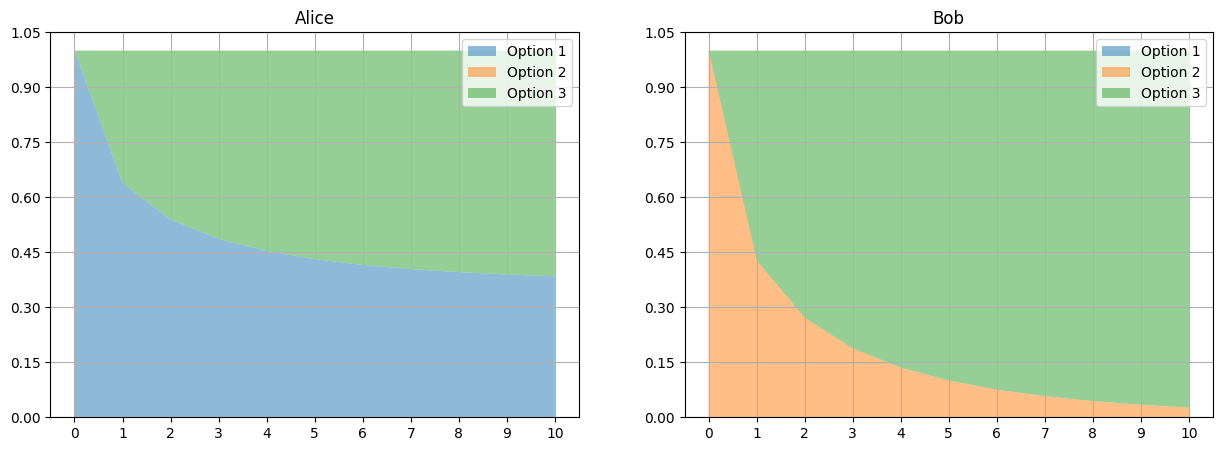

In [24]:
alice = [1, 0, 0]
bob   = [0, 1, 0]

communicate(alice, bob, random_transition, 10)

### Same strong preferences

Observation: Preferences don't change, as expected

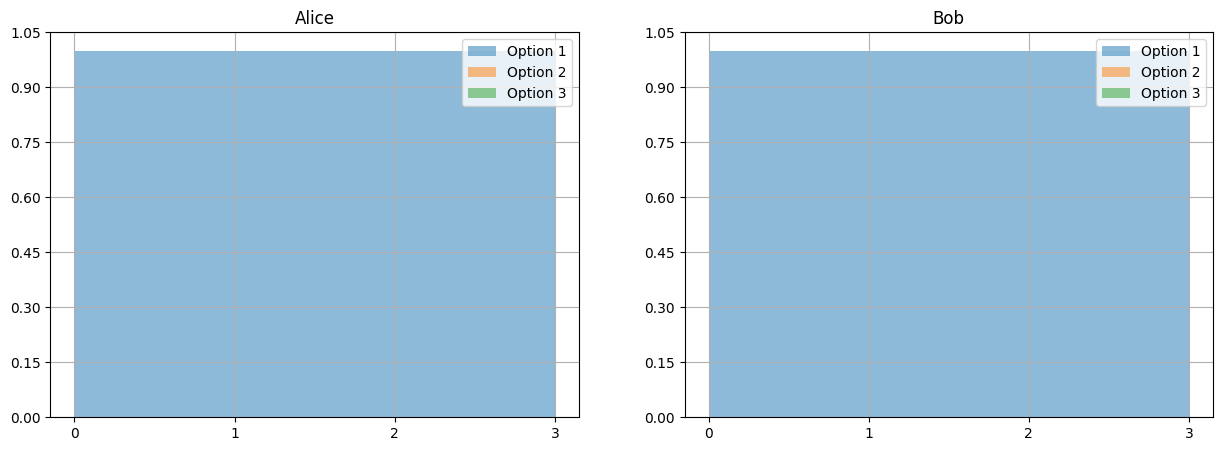

In [25]:
alice = [1, 0, 0]
bob   = [1, 0, 0]

communicate(alice, bob, random_transition, 3)

### Same weaker preferences

Observations:
- Both move towards third option

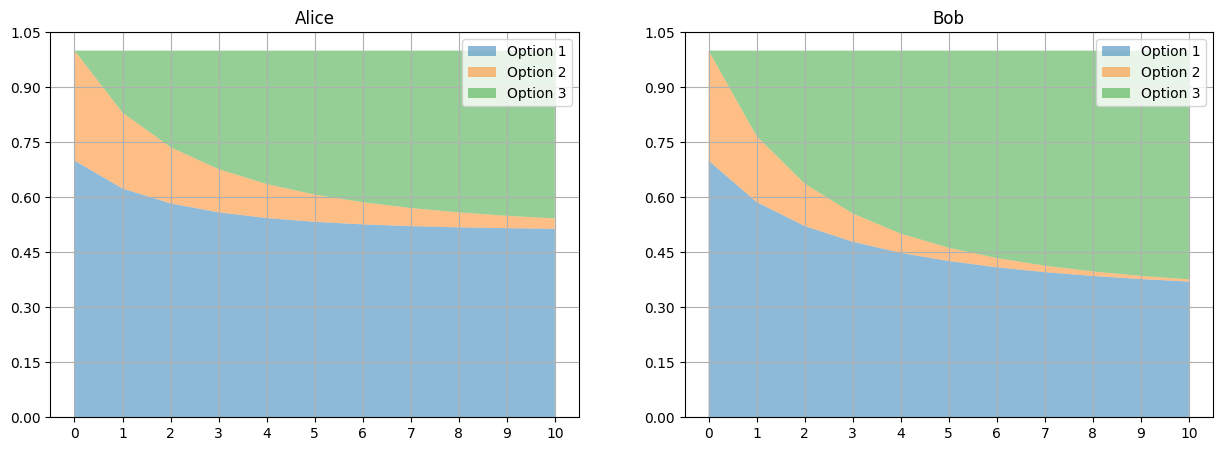

In [26]:
alice = [0.7, 0.3, 0]
bob   = [0.7, 0.3, 0]
communicate(alice, bob, random_transition, 10)


### Alice's strong preference

Observations:
- Bob keeps preference to Alice's opinion, his "other" option moves to third option
- Alice's preference moves heavily towards option 3, even though it shouldn't <== **PROBLEM?**
- Perhaps can be fixed by the same balancing of the transition matrix as in [Different strong preferences](#Different-strong-preferences)


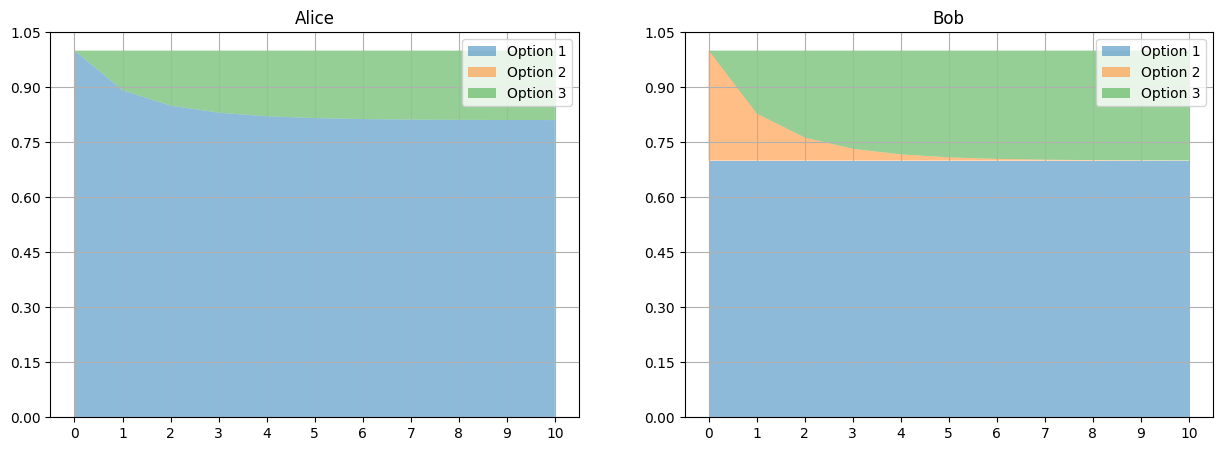

In [27]:
alice = [1, 0, 0]
bob   = [0.7, 0.3, 0]
communicate(alice, bob, random_transition, 10)

## Resistance and Charisma

- Resistance $r$ - probability of keeping current opinion
- Charisma $p$ - probability of persuading the other person

For a given actor:
- high resistance, low persuasion - will stick to his option, but will not convince others.
- high resistance, high persuasion - will stick to his option, and will convince others.
- low resistance, low persuasion - will change his opinion, and will not convince others.
- low resistance, high persuasion - ready to change his own opinion, easily convinces others.

(vA, vB)
- -> (vA, vA): Alice persuades Bob - Alice is charismatic AND Bob is not resistant $c_A \cdot (1 - r_B)$
- -> (vB, vB): Bob persuades Alice - Bob is charismatic AND Alice is not resistant $c_B \cdot (1 - r_A)$
- -> (vB, vA): They persuade each other - both are charismatic AND not resistant $c_A \cdot c_B \cdot (1 - r_A) \cdot (1 - r_B)$
- -> (vA, vB): Both keep their opinions - both are resistant and not charismatic $r_A \cdot r_B \cdot (1 - c_A) \cdot (1 - c_B)$

- -> (vA, vThird): Bob goes for third option - Bob is resistant AND Alice is charismatic $r_B \cdot c_A$
- -> (vB, vThird): Bob persuades Alice, but goes for third option himself **XXX DOESN'T MAKE SENSE**
- -> (vThird, vA): Alice persuades Bob, but goes for third option herself **XXX DOESN'T MAKE SENSE**
- -> (vThird, vB): Alice goes for third option - Alice is resistant AND Bob is charismatic $r_A \cdot c_B$
- -> (vThird, vThird): Both go for same option - both are charismatic AND resistant $c_A \cdot c_B \cdot r_A \cdot r_B$

In [28]:
def set_weighted_options(transition, vA, vB, ca, ra, cb, rb):
    va_va = ca * (1 - rb)
    va_vb = ra * rb * (1 - ca) * (1 - cb)
    va_vthird = rb * ca
    vb_va = ca * cb * (1 - ra) * (1 - rb)
    vb_vb = cb * (1 - ra)
    vb_vthird = 0
    vthird_va = 0
    vthird_vb = ra * cb
    vthird_vthird = ca * cb * ra * rb

    vThird = 3
    transition[locate((vA, vB), (vA, vB))] = va_vb # Both keep their opinion
    transition[locate((vA, vB), (vA, vA))] = va_va # Alice persuades Bob
    transition[locate((vA, vB), (vB, vB))] = vb_vb # Bob persuades Alice
    transition[locate((vA, vB), (vB, vA))] = vb_va # They persuade each other

    # Impossible transitions
    transition[locate((vA, vB), (vThird, vA))] = vthird_va  # Alice persuades Bob and goes for option 3
    transition[locate((vA, vB), (vB, vThird))] = vb_vthird # Bob persuades Alice and goes for option 3

    # third option transitions
    transition[locate((vA, vB), (vA, vThird))] = va_vthird # Bob goes for option 3
    transition[locate((vA, vB), (vThird, vB))] = vthird_vb # Alice goes for option 3
    transition[locate((vA, vB), (vThird, vThird))] = vthird_vthird # Both go for option 3

def build_weighted_matrix(ca, ra, cb, rb):
    transition = np.zeros((9, 9))

    # By default, all states are absorbing
    np.fill_diagonal(transition, 1)

    # Different opinions, can't persuade each other
    # Can be modified in case we want to allow persuasion
    set_weighted_options(transition, 1, 2, ca, ra, cb, rb)
    set_weighted_options(transition, 2, 1, ca, ra, cb, rb)

    # Normalize
    transition = transition / transition.sum(axis=1)[:, None]
    return transition

### Alice and Bob are charismatic and resistant

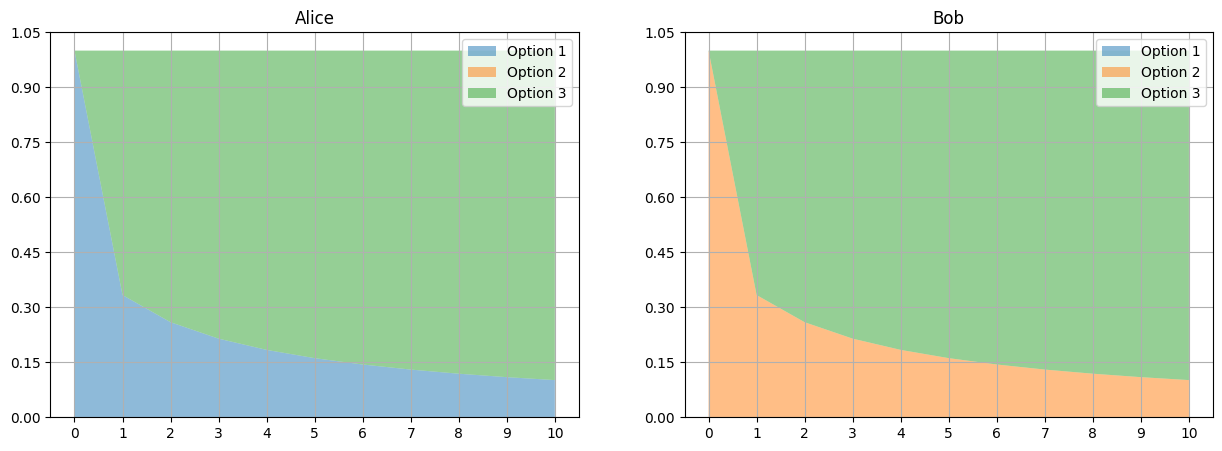

In [29]:
ca, ra = 1.0, 1.0
cb, rb = 1.0, 1.0
transition = build_weighted_matrix(ca, ra, cb, rb)
# print_transition_matrix(transition)

alice = [1, 0, 0]
bob   = [0, 1, 0]

communicate(alice, bob, transition, 10)

### Alice charismatic, Bob open-minded

		| (1,1)	| (1,2)	| (1,3)	| (2,1)	| (2,2)	| (2,3)	| (3,1)	| (3,2)	| (3,3)
---------------------------------------------------------------------------------
(1,1) 	|    1	|    0	|    0	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(1,2) 	| 0.304	|    0	| 0.13	|    0	|    0	|    0	|    0	| 0.435	| 0.13
---------------------------------------------------------------------------------
(1,3) 	|    0	|    0	|    1	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,1) 	|    0	|    0	|    0	|    0	| 0.304	| 0.13	| 0.435	|    0	| 0.13
---------------------------------------------------------------------------------
(2,2) 	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,3) 	|    0	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0
----------

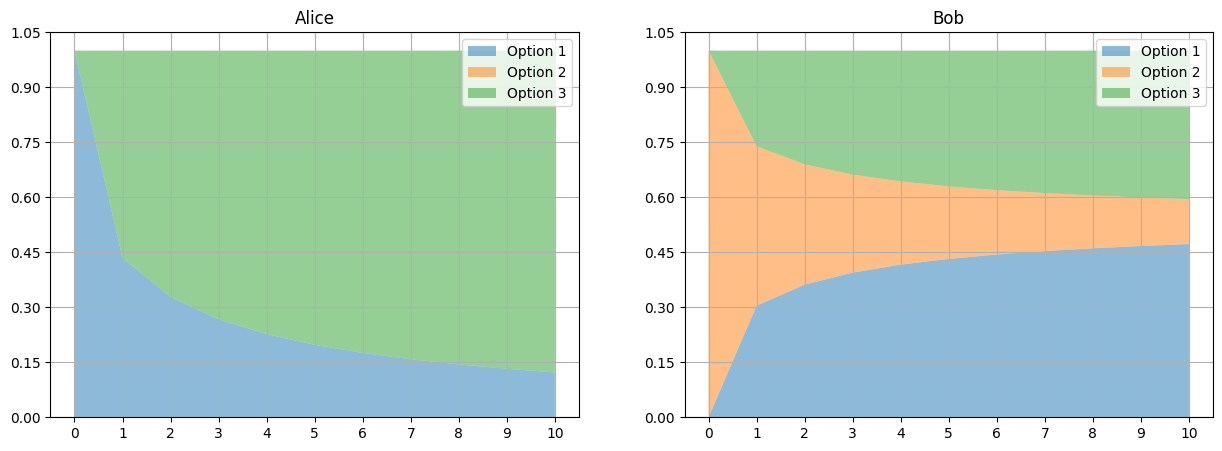

In [30]:
ca, ra = 1.0, 1.0
cb, rb = 1.0, 0.3
transition = build_weighted_matrix(ca, ra, cb, rb)
print_transition_matrix(transition)

alice = [1, 0, 0]
bob   = [0, 1, 0]

communicate(alice, bob, transition, 10)

### Alice charismatic, Bob open-minded and not charismatic

Bob's charisma influences him sticking to his opinion. Why? He's not charismatic, hence chances of moving Alice to third option is lower.
And given the matrix is normalized, It gives more chance for va_va transition

		| (1,1)	| (1,2)	| (1,3)	| (2,1)	| (2,2)	| (2,3)	| (3,1)	| (3,2)	| (3,3)
---------------------------------------------------------------------------------
(1,1) 	|    1	|    0	|    0	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(1,2) 	| 0.504	|    0	| 0.216	|    0	|    0	|    0	|    0	| 0.216	| 0.065
---------------------------------------------------------------------------------
(1,3) 	|    0	|    0	|    1	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,1) 	|    0	|    0	|    0	|    0	| 0.504	| 0.216	| 0.216	|    0	| 0.065
---------------------------------------------------------------------------------
(2,2) 	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,3) 	|    0	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0
------

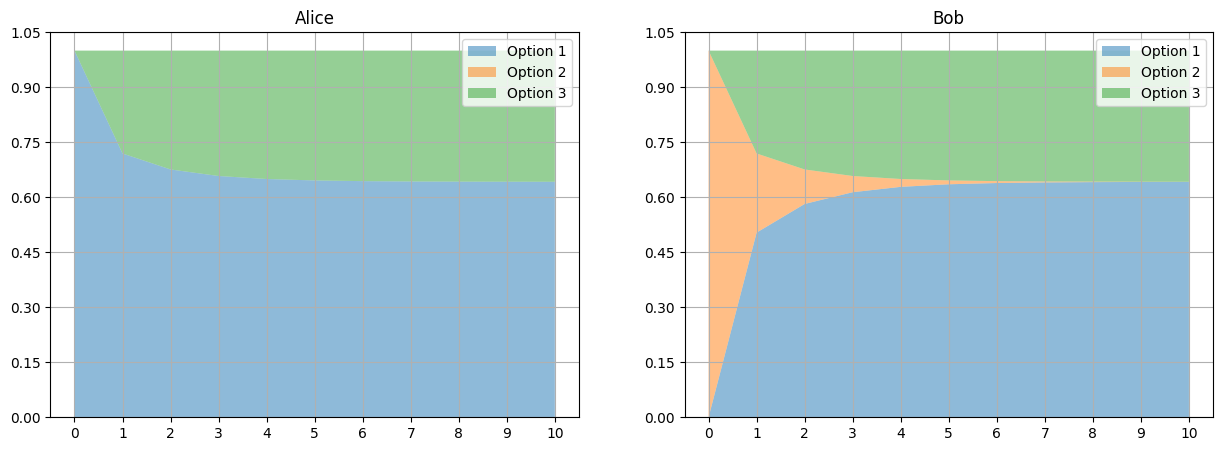

In [31]:
ca, ra = 1.0, 1.0
cb, rb = 0.3, 0.3
transition = build_weighted_matrix(ca, ra, cb, rb)
print_transition_matrix(transition)

alice = [1, 0, 0]
bob   = [0, 1, 0]

communicate(alice, bob, transition, 10)

# Both charismatic and open-minded

		| (1,1)	| (1,2)	| (1,3)	| (2,1)	| (2,2)	| (2,3)	| (3,1)	| (3,2)	| (3,3)
---------------------------------------------------------------------------------
(1,1) 	|    1	|    0	|    0	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(1,2) 	| 0.271	|    0	| 0.116	| 0.19	| 0.271	|    0	|    0	| 0.116	| 0.035
---------------------------------------------------------------------------------
(1,3) 	|    0	|    0	|    1	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,1) 	| 0.271	| 0.19	|    0	|    0	| 0.271	| 0.116	| 0.116	|    0	| 0.035
---------------------------------------------------------------------------------
(2,2) 	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,3) 	|    0	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0
----

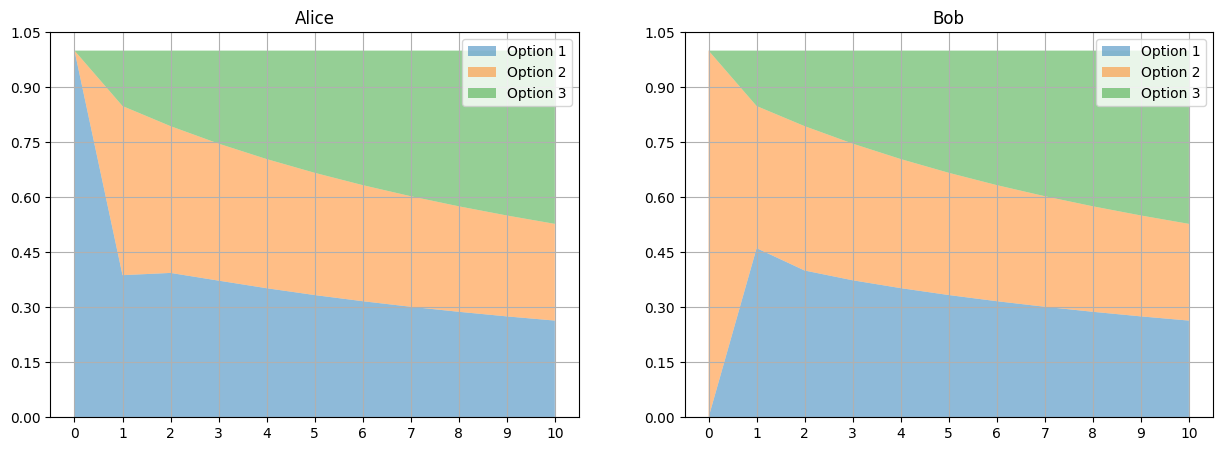

In [45]:
ca, ra = 1.0, 0.3
cb, rb = 1.0, 0.3
transition = build_weighted_matrix(ca, ra, cb, rb)
print_transition_matrix(transition)

alice = [1, 0, 0]
bob   = [0, 1, 0]

communicate(alice, bob, transition, 10)

# Original model

In [44]:
p = 0
q = 0
transition_orig = np.array([[p , 1 - p], [1 - q, q]])
print(transition_orig)

alice = [1.0, 0]
bob = [0, 1]

joint = np.array([alice, bob])
# print("\nFrom")
# print(joint)

result = np.dot(transition_orig, joint)
result2 = np.dot(transition_orig, result)

print("\nTo")
print(alice, "->", result[0], "->", result2[0])
print(bob, "->", result[1], "->", result2[1])



[[0 1]
 [1 0]]

To
[1.0, 0] -> [ 0.000  1.000] -> [ 1.000  0.000]
[0, 1] -> [ 1.000  0.000] -> [ 0.000  1.000]


In [34]:
def t():
    return (1, 2)
arr = np.ndarray((3, 3))
arr[1, 2] = 10
arr[t()]


10.0

# Sandbox

[[ 0.700  0.300  0.000]
 [ 0.600  0.218  0.182]
 [ 0.548  0.166  0.286]
 [ 0.516  0.130  0.354]]

[[ 0.700  1.000  1.000]
 [ 0.600  0.818  1.000]
 [ 0.548  0.714  1.000]
 [ 0.516  0.646  1.000]]


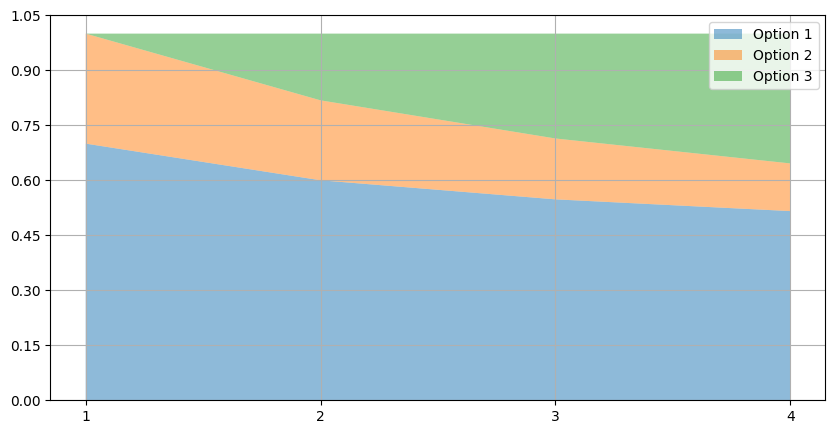

In [35]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
alice = np.array([[ 0.700,  0.300,  0.000],
[ 0.600, 0.218,  0.182],
[ 0.548,  0.166,  0.286],
[ 0.516,  0.130,  0.354]])

print(alice)
alice_cumsum = np.cumsum(alice, axis=1)
print()
print(alice_cumsum)

plt.figure(figsize=(10, 5))
x = np.arange(alice_cumsum.shape[0])
# plt.plot(alice_cumsum)
for i in range(3):
    baseline = 0 if i == 0 else alice_cumsum[:, i-1]    
    plt.fill_between(x, baseline, alice_cumsum[:, i], label=f'Option {i+1}', alpha=0.5)

plt.xticks(ticks=x, labels=[f'{i+1}' for i in x])

plt.legend()
plt.ylim(bottom=0)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))
plt.grid()
plt.show()

# Archive

In [36]:
    # transition[locate((1, 2), (1, 2))] = np.random.rand() # Both keep their opinion
# transition[locate((1, 2), (1, 1))] = 0 # Alice persuades Bob
# transition[locate((1, 2), (2, 2))] = 0 # Bob persuades Alice
# transition[locate((1, 2), (2, 1))] = 0 # They persuade each other
# 
# # Impossible transitions
# transition[locate((1, 2), (3, 1))] = 0  # Alice persuades Bob and goes for option 3
# transition[locate((1, 2), (2, 3))] = 0 # Bob persuades Alice and goes for option 3
# 
# # third option transitions
# transition[locate((1, 2), (1, 3))] = np.random.rand() # Bob goes for option 3
# transition[locate((1, 2), (3, 2))] = np.random.rand() # Alice goes for option 3
# transition[locate((1, 2), (3, 3))] = np.random.rand() # Both go for option 3
# 
# # Different opinions, can't persuade each other
# transition[locate((2, 1), (2, 1))] = np.random.rand() # Both keep their opinion
# transition[locate((2, 1), (2, 2))] = 0 # Alice persuades Bob
# transition[locate((2, 1), (1, 1))] = 0 # Bob persuades Alice
# transition[locate((2, 1), (1, 2))] = 0 # They persuade each other
# 
# # Impossible transitions
# transition[locate((2, 1), (3, 2))] = 0 # Alice persuades Bob and goes for option 3
# transition[locate((2, 1), (1, 3))] = 0 # Bob persuades Alice and goes for option 3
# 
# # third option transitions
# transition[locate((2, 1), (2, 3))] = np.random.rand() # Bob goes for option 3
# transition[locate((2, 1), (3, 1))] = np.random.rand() # Alice goes for option 3
# transition[locate((2, 1), (3, 3))] = np.random.rand() # Both go for option 3

## Transition matrix setup

In [37]:
p = 0.5
q = 0.5
both = p*q
remain = 1 - p - q - both

pn = p / (p + q + both)
qn = q / (q + p + both)
bothn = both / (both + p + q)

print(pn, qn, bothn)
print(1 - pn - qn - bothn)

0.4 0.4 0.2
-5.551115123125783e-17
